In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install rarfile


In [4]:
import rarfile

# Path to the RAR file on Google Drive
rar_file_path = '/content/drive/MyDrive/PlantVillage.rar'

# Path to the directory where you want to extract the files
extract_dir_path = '/content/Plant_Uncompressed/'

# Extract the RAR file
with rarfile.RarFile(rar_file_path, 'r') as rar_ref:
    rar_ref.extractall(extract_dir_path)

print("Extraction complete.")


Extraction complete.


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Plant_Uncompressed/PlantVillage",
    shuffle= True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE



)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

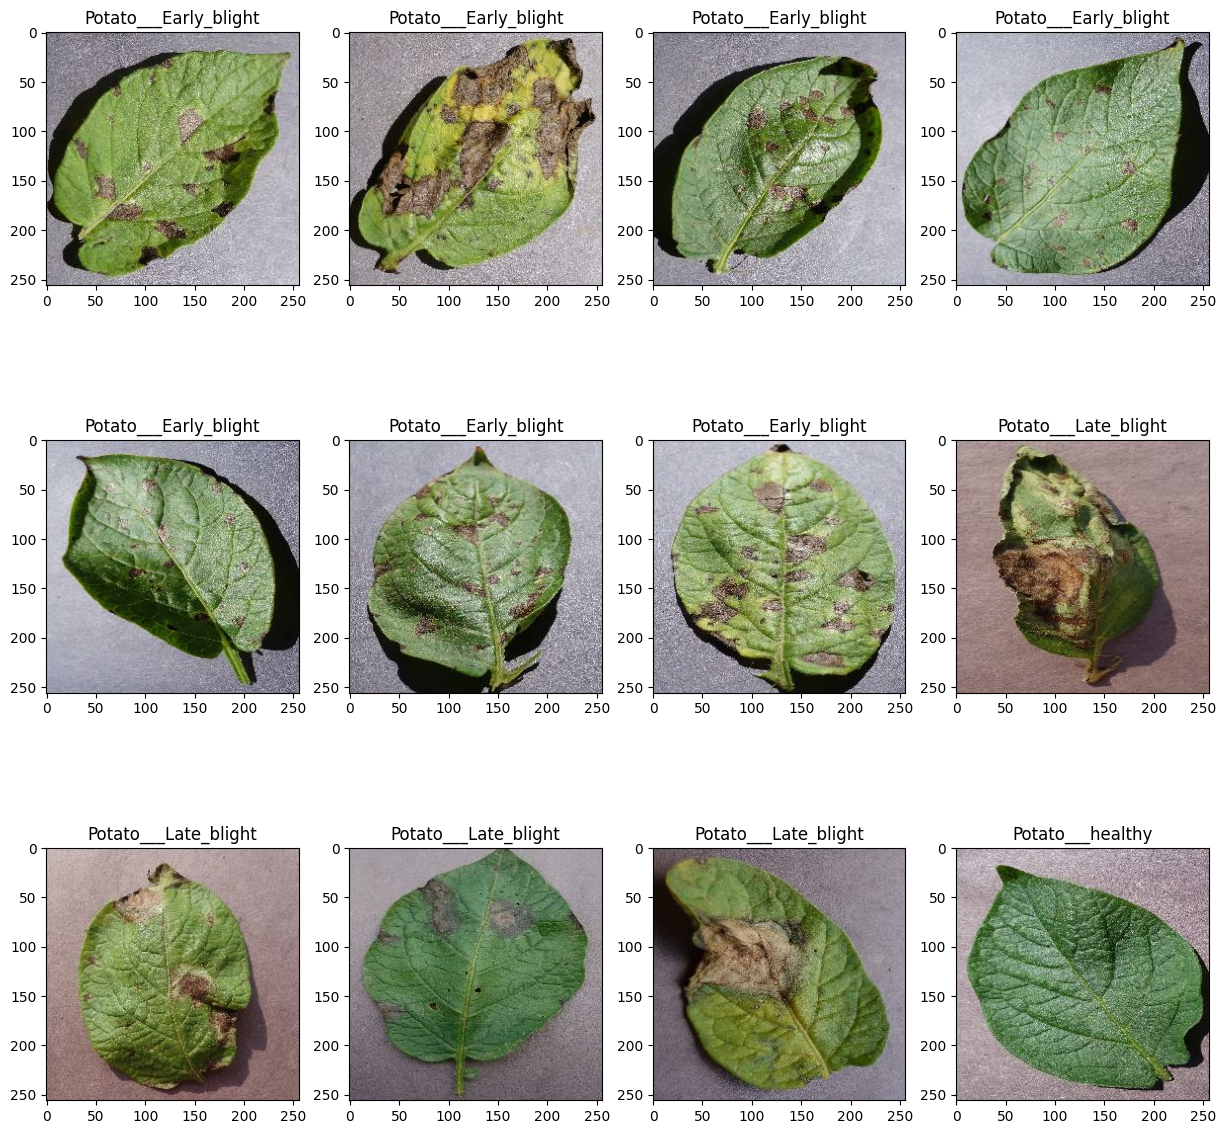

In [9]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
    #   plt.axis("off")
    #     print(image_batch)
    #     print(label_batch.numpy())

In [10]:
# 80% => training
# 20% => 10% Validation, 10% Test

In [11]:
train_size = 0.8
len (dataset)* train_size


54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len (dataset)*val_size


6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
# We know make a function which will do all the obove step by using nice python scripts

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size= int(train_split * ds_size)
    val_size = int (val_split * ds_size)

    train_ds = ds.take (train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(test_ds)

8

In [22]:
len(val_ds)

6

In [23]:
#It will improve the model performance by consuming less time than usual by prefetch and cache methods

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [25]:
#LAYERS OF PREPROCESSING

In [26]:
#Usually the numpy file is between 0-255 but we want it to be in the range of 0-1
#Along with that we want to make sure that our dataset only consists of 256*256 images so to do that we will use resizing code

In [27]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
#We also used data augmentation as it will help to make our model more robust and it also increases our dataset which helps model to make it more precise

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
#Model Training (Network Architecture)

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [33]:
#Model Compile

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
#Model training

In [39]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
54/54 [==============================] - 4s 73ms/step - loss: 0.0285 - accuracy: 0.9907 - val_loss: 0.0413 - val_accuracy: 0.9896
Epoch 2/50
54/54 [==============================] - 3s 60ms/step - loss: 0.0208 - accuracy: 0.9925 - val_loss: 0.0602 - val_accuracy: 0.9844
Epoch 3/50
54/54 [==============================] - 3s 61ms/step - loss: 0.0235 - accuracy: 0.9913 - val_loss: 0.0416 - val_accuracy: 0.9896
Epoch 4/50
54/54 [==============================] - 3s 61ms/step - loss: 0.0208 - accuracy: 0.9925 - val_loss: 0.0551 - val_accuracy: 0.9896
Epoch 5/50
54/54 [==============================] - 3s 63ms/step - loss: 0.0217 - accuracy: 0.9919 - val_loss: 0.0674 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 3s 61ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.0753 - val_accuracy: 0.9948
Epoch 7/50
54/54 [==============================] - 3s 62ms/step - loss: 0.0054 - accuracy: 0.9977 - val_loss: 0.0525 - val_accuracy: 0.9844
Epoch 8/50
54

In [40]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 21ms/step - loss: 0.0464 - accuracy: 0.9805


In [ ]:
#Evaluating Metrices

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
#Plotting Graphs

Text(0.5, 1.0, 'Training and Validation Accuracy')

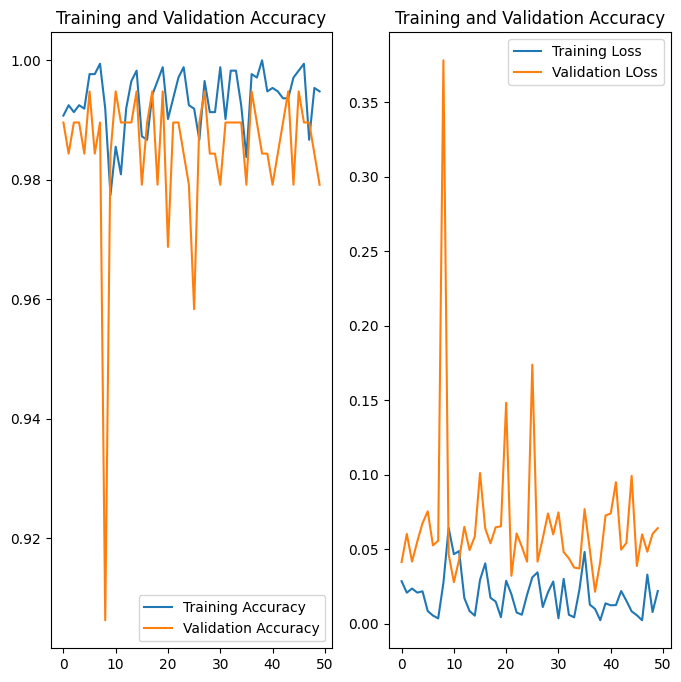

In [46]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title ("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation LOss")
plt.legend(loc='upper right')
plt.title ("Training and Validation Accuracy")

In [47]:
#Prediction

First image to predict
actual label Potato___Early_blight
1/1 [==============================] - 0s 30ms/step
predicted label: Potato___Early_blight


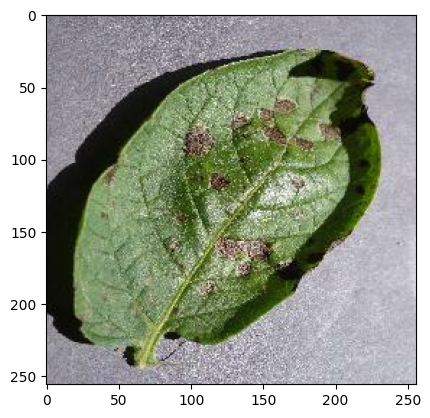

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("actual label", class_names [first_label])

  batch_prediction = model.predict(image_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [68]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # Create Batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round (100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


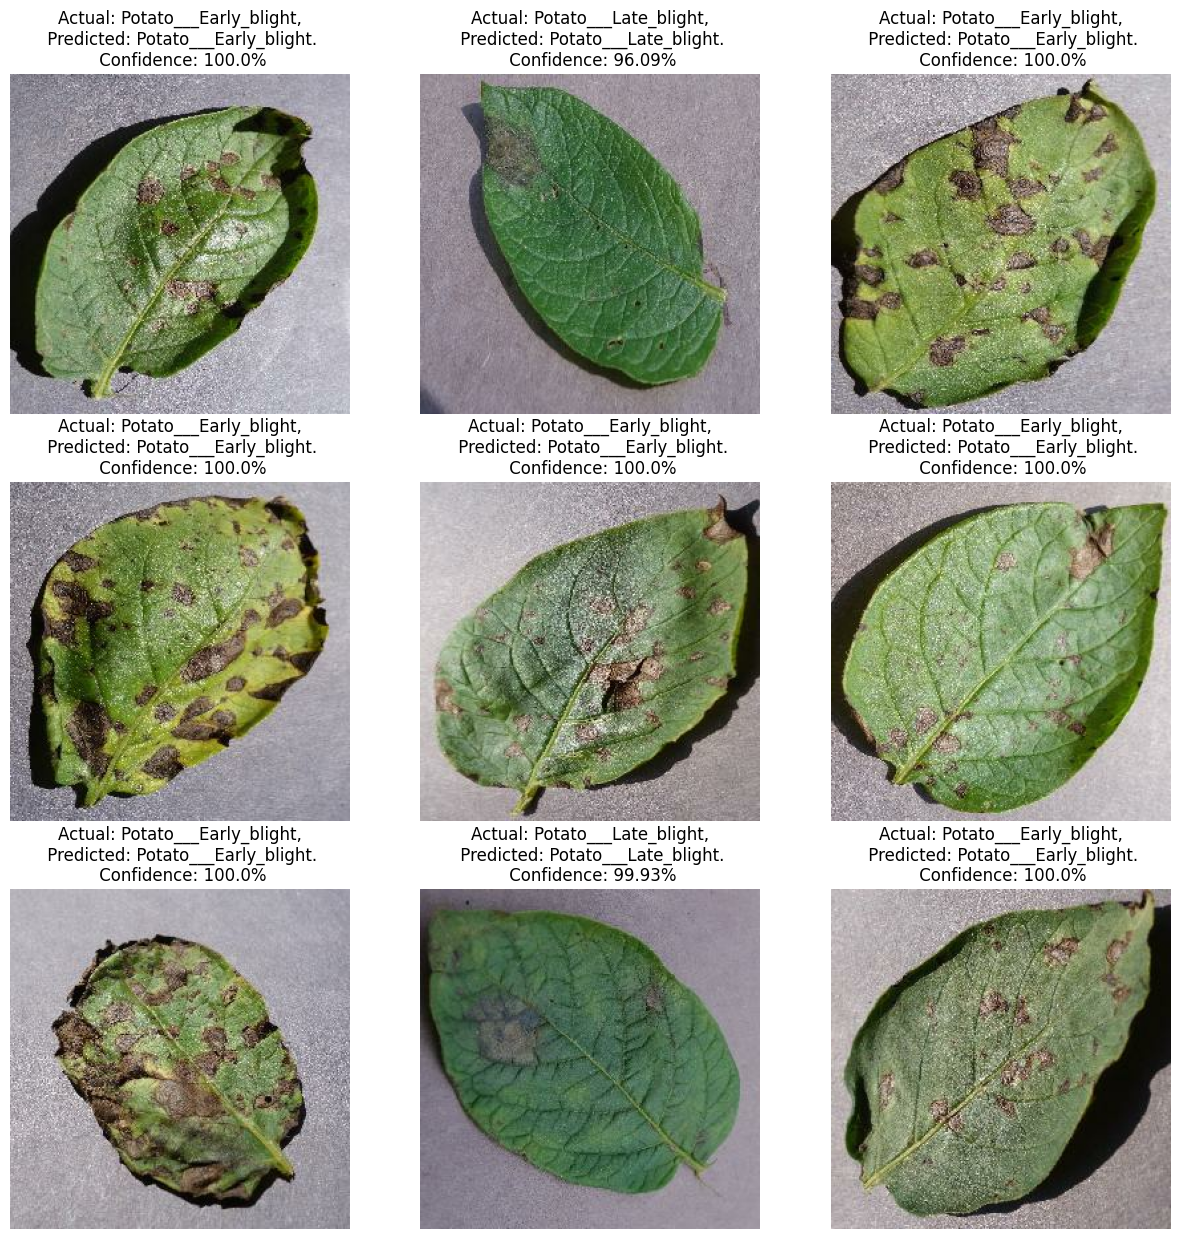

In [74]:
plt.figure(figsize= (15,15))
for images, labels in test_ds.take(1):
  for i in range (9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("Off")

In [77]:
import os
model_version = max([int(i) for i in os.listdir("/content/Models/")+[0]])+1
model.save(f"/content/Models/{model_version}")

In [1]:
#Model Deployment USing Pickle and AWS

In [3]:
import pickle

In [5]:
pickle.dump(model,open("model.pkl"))

NameError: name 'model' is not defined